In [62]:
import hume_wsds as wsds
import math
from IPython.display import display, Audio, Markdown
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [71]:
class WSGetDuration:
    def __init__(self, sample_rate=16000):
        self.sample_rate = sample_rate
        self.parent_dataset = None
        self.shard_name = None

    def get_sample(self, _column, offset):
        audio = self.parent_dataset.get_sample(self.shard_name, "audio", offset)
        return audio.tend - audio.tstart 

    @classmethod
    def from_link(cls, link, source_dataset, parent_dataset, shard_name):
        inst = cls()
        inst.parent_dataset = parent_dataset
        inst.shard_name = shard_name
        return inst

class WSFilterBoolean:
    def __init__(self, snr_thresh=10.0, cps_thresh=20.0, duration_thresh=1, text_key='transcription_wslang_raw.txt', sample_rate=16000):
        self.snr_thresh = snr_thresh
        self.cps_thresh = cps_thresh
        self.duration_thresh = duration_thresh
        self.sample_rate = sample_rate
        self.text_key = text_key
        self.parent_dataset = None
        self.shard_name = None

    def get_sample(self, _column, offset):
        snr = float(self.parent_dataset.get_sample(self.shard_name, "snr", offset))
        txt = self.parent_dataset.get_sample(self.shard_name, self.text_key, offset)

        try:
            duration_sec = float(self.parent_dataset.get_sample(self.shard_name, "duration", offset))
        except KeyError:
            audio = (
                self.parent_dataset.get_sample(self.shard_name, "audio", offset)
                .load(self.sample_rate)
                .numpy()
            )
            duration_sec = audio.shape[-1] / self.sample_rate

        cps = len(txt) / duration_sec if duration_sec > 0 else float("inf")
        return (snr > self.snr_thresh) and (cps < self.cps_thresh) and (duration_sec  > self.duration_thresh)

    @classmethod
    def from_link(cls, link, source_dataset, parent_dataset, shard_name):
        config = link.get("config", {})
        inst = cls(
            snr_thresh=config.get("snr_thresh", 10.0),
            cps_thresh=config.get("cps_thresh", 20.0),
            duration_thresh=config.get("duration_thresh", 1.0),
            text_key=config.get("text_key", "transcription_wslang_raw.txt"),
        )
        inst.parent_dataset = parent_dataset
        inst.shard_name = shard_name
        return inst


        
ds = wsds.WSDataset("/mnt/weka/data-wsds/wyndlabs_1M-it/v5-diarized_continuous/")
text_key = 'transcription_wslang_continuous.txt'

ds.add_computed(
    "duration",
    dataset_dir="../source",
    loader=WSGetDuration
)

ds.add_computed(
    "passed-filter",
    dataset_dir="../source",
    loader=WSFilterBoolean,  
    config=dict(
        snr_thresh=10.0,
        cps_thresh=20.0,
        duration_thresh=0.5,
        text_key=text_key
    )
)
rows = []
MAX_SAMPLES = 10 

for i, sample in tqdm(enumerate(ds)):
    if not sample["passed-filter"]:
        continue 

    snr = float(sample["snr"])
    txt = sample[text_key]

    duration_sec = sample["duration"]
    cps = len(txt) / duration_sec if duration_sec > 0 else 0

    rows.append({
        "key": sample.get_key(),
        text_key: txt,
        "snr": snr,
        "duration": duration_sec,
        "cps": cps,
    })

    if i >= MAX_SAMPLES:
        break

df = pd.DataFrame(rows)

10it [00:00, 93.11it/s]


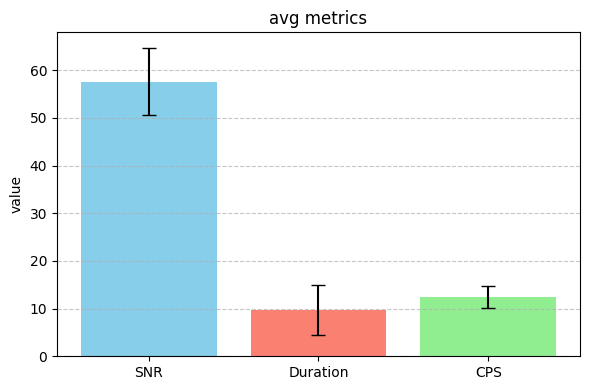

In [72]:
metrics = {
    "SNR": {"mean": df["snr"].mean(), "std": df["snr"].std()},
    "Duration": {"mean": df["duration"].mean(), "std": df["duration"].std()},
    "CPS": {"mean": df["cps"].mean(), "std": df["cps"].std()},
}

labels = list(metrics.keys())
means = [metrics[m]["mean"] for m in labels]
stds = [metrics[m]["std"] for m in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, means, yerr=stds, capsize=5, color=["skyblue", "salmon", "lightgreen"])

plt.title("avg metrics")
plt.ylabel("value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [74]:
for i, sample in enumerate(ds):

    if not sample["passed-filter"]:
        continue 

    audio = sample['audio'].load(16000).numpy()
    txt = sample[text_key]
    snr = float(sample['snr'])

    duration_sec = sample['duration']
    cps = len(txt) / duration_sec if duration_sec > 0 else 0

        
    display(Markdown(f"### Sample {i+1}: `{sample.get_key()}`"))
    display(Markdown(f"- Transcript: `{txt}`"))
    display(Markdown(f"- Duration: {duration_sec:.1f}s"))
    display(Markdown(f"- SNR: {snr:.2f} | CPS: {cps:.2f}"))

    display(Audio(audio, rate=16000))

    if i >= 2:  
        break

### Sample 1: `NSdReRkeEdE/NSdReRkeEdE_00000023`

- Transcript: ` e sempre con la penna oro ho aggiunto qualche altra stellina qui quindi una cosa molto semplice però che fosse carina da vedere`

- Duration: 6.8s

- SNR: 48.91 | CPS: 18.96

### Sample 2: `NSdReRkeEdE/NSdReRkeEdE_00000024`

- Transcript: ` la parte successiva invece è il calendario annuale il calendario annuale vabbè me lo sono disegnato prima a matita perché è lunghissimo`

- Duration: 7.8s

- SNR: 48.25 | CPS: 17.55

### Sample 3: `NSdReRkeEdE/NSdReRkeEdE_00000025`

- Transcript: ` devi controllare di scrivere 20 giorni e in realtà l'anno scorso l'avevo semplicemente stampato l'avevo disegnato a computer, l'avevo stampato`

- Duration: 9.5s

- SNR: 49.91 | CPS: 15.05